In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn.metrics import accuracy_score
from tabulate import tabulate
from sklearn.manifold import TSNE

In [3]:
pd.options.display.float_format = '{:20,.2f}'.format  #https://stackoverflow.com/questions/17737300/suppressing-scientific-notation-in-pandas

In [4]:
# Loading data

train_path = 'C:/Users/sdiva/Documents/Python_scripts/AAIC/BO/dataset/Kaggle_Training_Dataset_v2.csv'
test_path = 'C:/Users/sdiva/Documents/Python_scripts/AAIC/BO/dataset/Kaggle_Test_Dataset_v2.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

C:\Users\sdiva\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
train_data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,-99.00,-99.00,0.00,No,No,No,Yes,No,No
1,1043384,2.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.99,0.99,0.00,No,No,No,Yes,No,No
2,1043696,2.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,-99.00,-99.00,0.00,Yes,No,No,Yes,No,No
3,1043852,7.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.10,0.13,0.00,No,No,No,Yes,No,No
4,1044048,8.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,-99.00,-99.00,0.00,Yes,No,No,Yes,No,No


In [4]:
train_data.shape

(1687861, 23)

In [5]:
#Checking if there are multiple entries for same SKU. Since there aren't, we can keep the sku column 
#on stand-by as our model doesn't get any additional information from it directly.

train_data.groupby(['sku']).count().shape

(1687861, 22)

In [5]:
#Dropping sku column and separating y data

train_y = train_data.iloc[:,-1] 
train_x = train_data.drop(train_data.columns[[0,-1]], axis=1)
test_x = test_data.drop(test_data.columns[0], axis=1)

In [6]:
# Checking for nulls/nans

train_x.isnull().sum()

national_inv              1
lead_time            100894
in_transit_qty            1
forecast_3_month          1
forecast_6_month          1
forecast_9_month          1
sales_1_month             1
sales_3_month             1
sales_6_month             1
sales_9_month             1
min_bank                  1
potential_issue           1
pieces_past_due           1
perf_6_month_avg          1
perf_12_month_avg         1
local_bo_qty              1
deck_risk                 1
oe_constraint             1
ppap_risk                 1
stop_auto_buy             1
rev_stop                  1
dtype: int64

In [6]:
#Dropping the last row which doesn't have any values

train_x.drop(train_x.tail(1).index,inplace=True)
train_y.drop(train_y.tail(1).index,inplace=True)

In [8]:
# Checking distribution for rows where lead time is null

lead_time_null = train_data[train_data['lead_time'].isnull()]
lead_time_null['went_on_backorder'].value_counts()

No     100569
Yes       324
Name: went_on_backorder, dtype: int64

In [14]:
# Checking distriubtion for lead time when there is a backorder

train_data[train_data['went_on_backorder']=='Yes']['lead_time'].value_counts()

 8.00    4744
 2.00    3457
12.00    1024
 9.00     536
 4.00     475
 3.00     204
 0.00     162
10.00      69
 6.00      54
 5.00      52
14.00      46
16.00      44
15.00      28
52.00      22
13.00      21
11.00      19
17.00      11
 7.00       1
Name: lead_time, dtype: int64

In [15]:
# # Checking distriubtion for lead time when there is no backorder

train_data[train_data['went_on_backorder']=='No']['lead_time'].value_counts()

 8.00    677442
 2.00    333945
12.00    198676
 4.00    128062
 9.00    123113
52.00     30091
 3.00     16049
10.00     14123
 0.00     10349
14.00     10268
16.00      8799
13.00      5384
 6.00      5311
 5.00      3979
15.00      3784
17.00      3752
11.00      1075
20.00       416
30.00       312
18.00       221
 7.00       208
22.00       133
24.00       115
26.00       105
28.00        84
21.00        49
40.00        48
35.00        35
19.00        28
 1.00        21
23.00        14
25.00         7
Name: lead_time, dtype: int64

Observations:
>-Approx 6.25% of rows have null values for lead_time <br>
>-lead_time variable distributions for Yes and NO backorders seem to be similar<br>
>-As compared to overall data, proportionately very few 'Yes' backorder rows in the data where lead_time is null<br>
>-And since we anyway have a huge data imbalance, we can remove rows where lead_time is null<br>

In [6]:
# Removing rows where lead_time is null

train_x = train_x[train_x['lead_time'].notnull()]
train_y = train_data[train_data['lead_time'].notnull()]['went_on_backorder']

### Target Variable Analysis:

In [37]:
train_y.value_counts()

Yes
0      1575998
1        10969
dtype: int64

~Ratio of No Backorders to Backorders:


In [12]:
int(train_y.value_counts()[0]/train_y.value_counts()[1])

148

### Target Observations:

> Given the imbalance, metrics like accuracy will not work. F1-score, AUROC or custom performance metrics will have to be considered.

In [8]:
# Verifying if there is any null data

train_x.isnull().sum()

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
dtype: int64

In [27]:
train_x.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,"1,586,967.00","1,586,967.00","1,586,967.00","1,586,967.00","1,586,967.00","1,586,967.00","1,586,967.00","1,586,967.00","1,586,967.00","1,586,967.00","1,586,967.00","1,586,967.00","1,586,967.00","1,586,967.00","1,586,967.00"
mean,489.51,7.87,45.47,188.74,365.34,536.28,56.91,178.48,352.23,544.13,53.20,2.17,-1.01,-0.55,0.63
std,"30,461.68",7.06,"1,309.36","5,182.99","10,099.62","14,825.76","1,854.77","4,971.13","9,679.30","15,148.71","1,119.03",243.40,13.27,11.45,33.44
min,"-27,256.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-99.00,-99.00,0.00
25%,4.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.69,0.69,0.00
50%,14.00,8.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,4.00,0.00,0.00,0.84,0.82,0.00
75%,78.00,9.00,0.00,5.00,15.00,25.00,5.00,16.00,33.00,50.00,3.00,0.00,0.97,0.96,0.00
max,"12,334,404.00",52.00,"489,408.00","1,427,612.00","2,461,360.00","3,777,304.00","741,774.00","1,105,478.00","2,146,625.00","3,205,172.00","205,786.00","146,496.00",1.00,1.00,"12,530.00"


>Barring lead_time, perf_6_month_avg and perf_12_month_avg, all other numberical variables are right skewed <br>
>Barring national_inv, perf_6_month_avg and perf_12_month_avg, all other numberical variables have '0' as the minimum value and it is also the mode 

### Multivariate Analysis:

#### Since many features are continuous, checking for collinearity with heatmap

<AxesSubplot:>

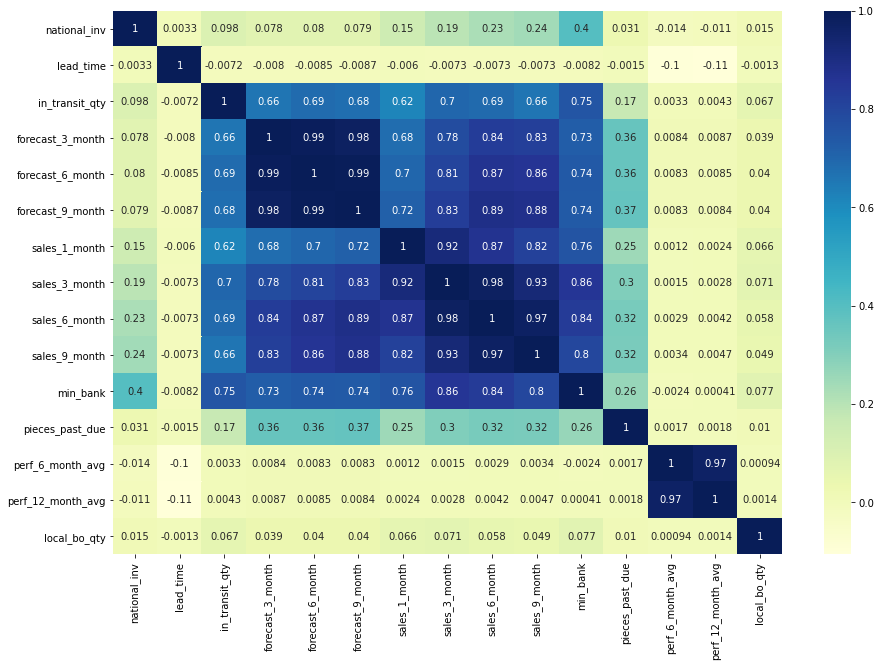

In [13]:
corr = train_x.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr,xticklabels = corr.columns,yticklabels = corr.columns,annot=True,cmap="YlGnBu")

In [9]:
#Storing col names having correlation more than the threshold

corr_col_set = set()
CORR_THRESHOLD = 0.7

In [10]:
col_list = corr.columns
for i in range(len(col_list)):
    for j in range(len(col_list)):
        if j<i:
            if abs(corr.iloc[i,j]) > CORR_THRESHOLD:
                corr_col_set.add(col_list[i])
            

In [11]:
corr_col_set

{'forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'min_bank',
 'perf_12_month_avg',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month'}

#### Observations:
> High correlation is observed between the sales columns and forecast columns<br>
> It may hence be better to retain 1 each from the group i.e sales_1_month and forecast_3_month


C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

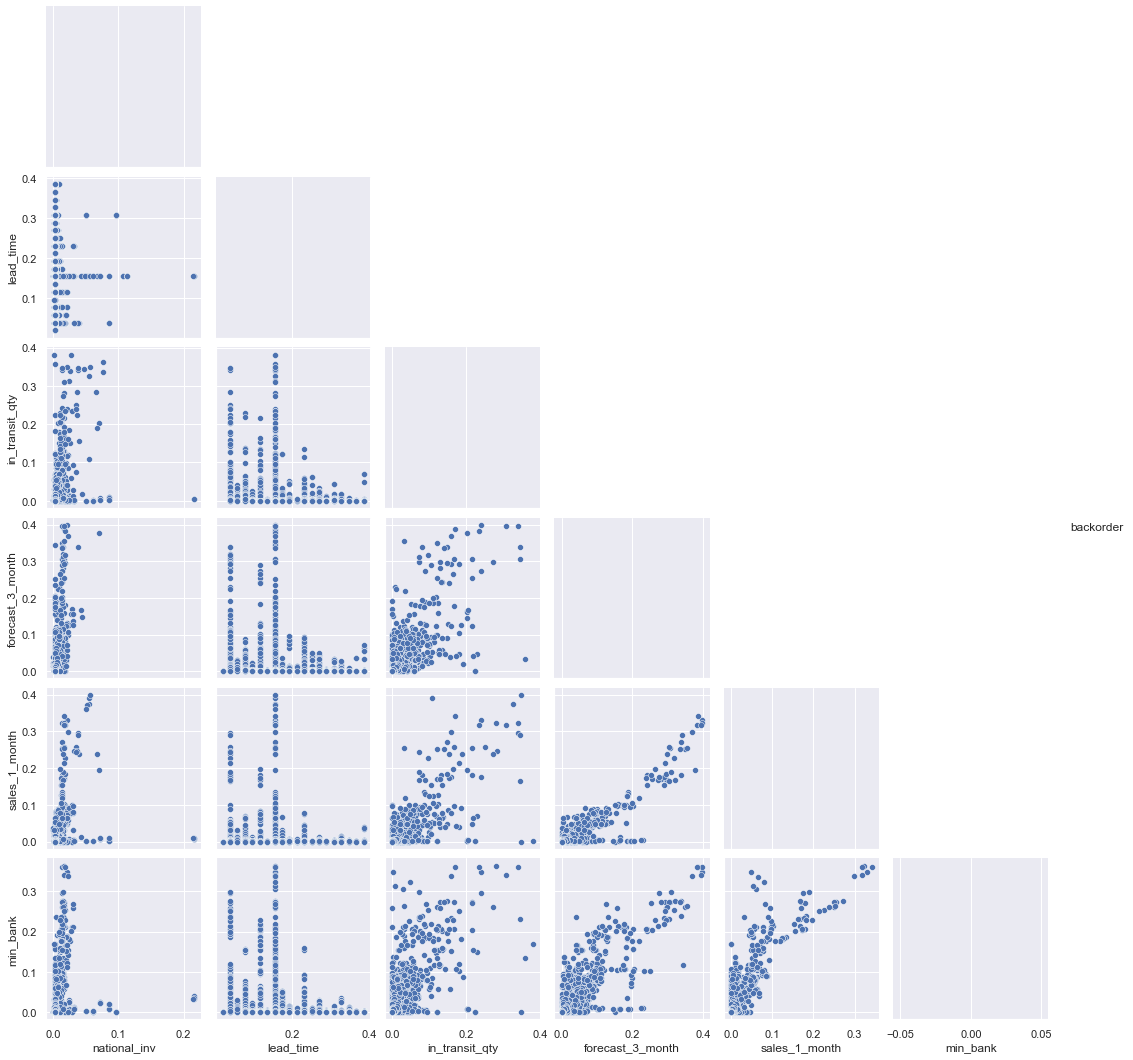

In [98]:
from sklearn.preprocessing import MinMaxScaler

pair_cols = ['national_inv','lead_time','in_transit_qty','forecast_3_month','sales_1_month','min_bank']
x_pair = train_x[pair_cols]
x_pair = MinMaxScaler().fit_transform(x_pair)
x_pair = pd.DataFrame(x_pair,columns=pair_cols)
x_pair['backorder'] = train_y
plot_kws={"s": 1}
sns.pairplot(x_pair[(x_pair[pair_cols]>0)&(x_pair[pair_cols]<0.4)],hue='backorder',corner='True')

#### Observations:
> Pairplots are inconclusive especially due to hugh imbalance. <br>


#### Univariate analysis:

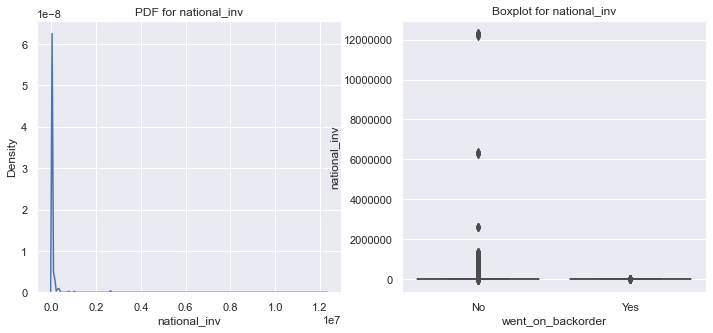

In [30]:
f, axes = plt.subplots(1, 2,figsize=(12,5))


sns.kdeplot(train_x['national_inv'],ax=axes[0]).set_title("PDF for national_inv")
plt.ticklabel_format(style='plain', axis='y')
sns.boxplot(y='national_inv',x='went_on_backorder',data=train_data,ax=axes[1]).set_title("Boxplot for national_inv")
plt.ticklabel_format(style='plain', axis='y')



#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

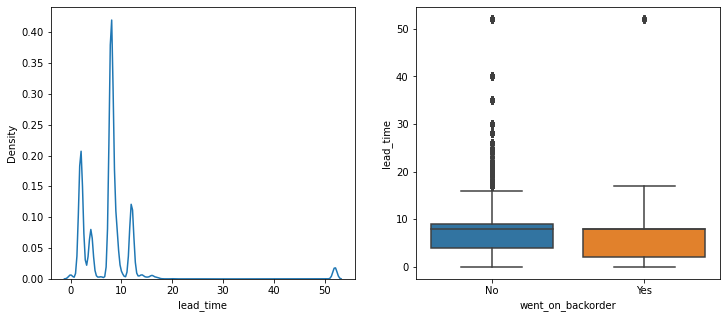

In [51]:
f, axes = plt.subplots(1, 2,figsize=(12,5))


sns.kdeplot(train_x['lead_time'],ax=axes[0]).set_title("PDF for lead_time")
plt.ticklabel_format(style='plain', axis='y')
sns.boxplot(y='lead_time',x='went_on_backorder',data=train_data,ax=axes[1]).set_title("Boxplot for lead_time")
plt.ticklabel_format(style='plain', axis='y')

#### Observation:
> Figures show high concentration of values at the start in the range of approx 3-18 days<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

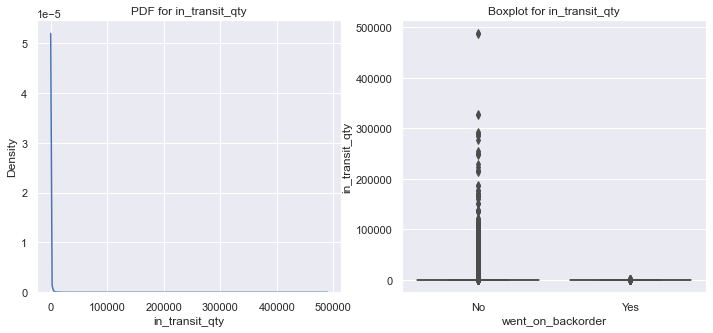

In [31]:
f, axes = plt.subplots(1, 2,figsize=(12,5))


sns.kdeplot(train_x['in_transit_qty'],ax=axes[0]).set_title("PDF for in_transit_qty")
plt.ticklabel_format(style='plain', axis='y')
sns.boxplot(y='in_transit_qty',x='went_on_backorder',data=train_data,ax=axes[1]).set_title("Boxplot for in_transit_qty")
plt.ticklabel_format(style='plain', axis='y')

#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

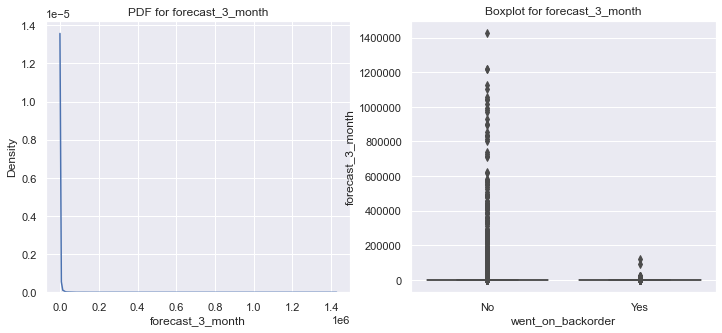

In [32]:
f, axes = plt.subplots(1, 2,figsize=(12,5))


sns.kdeplot(train_x['forecast_3_month'],ax=axes[0]).set_title("PDF for forecast_3_month")
plt.ticklabel_format(style='plain', axis='y')
sns.boxplot(y='forecast_3_month',x='went_on_backorder',data=train_data,ax=axes[1]).set_title("Boxplot for forecast_3_month")
plt.ticklabel_format(style='plain', axis='y')

#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

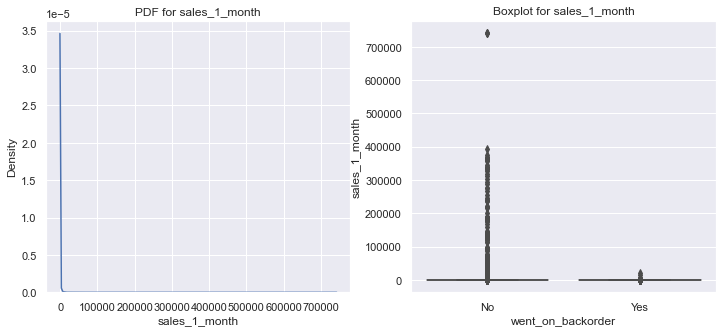

In [33]:
f, axes = plt.subplots(1, 2,figsize=(12,5))


sns.kdeplot(train_x['sales_1_month'],ax=axes[0]).set_title("PDF for sales_1_month")
plt.ticklabel_format(style='plain', axis='y')
sns.boxplot(y='sales_1_month',x='went_on_backorder',data=train_data,ax=axes[1]).set_title("Boxplot for sales_1_month")
plt.ticklabel_format(style='plain', axis='y')

#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

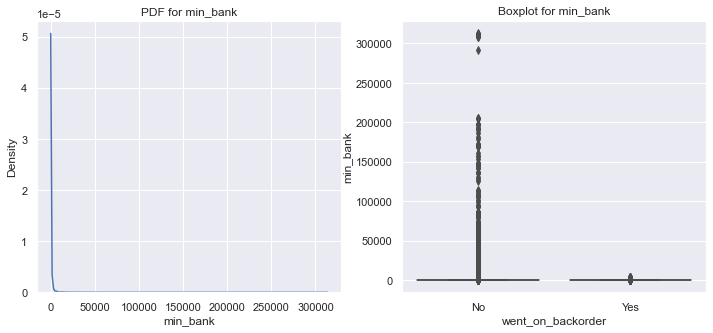

In [34]:
f, axes = plt.subplots(1, 2,figsize=(12,5))


sns.kdeplot(train_x['min_bank'],ax=axes[0]).set_title("PDF for min_bank")
plt.ticklabel_format(style='plain', axis='y')
sns.boxplot(y='min_bank',x='went_on_backorder',data=train_data,ax=axes[1]).set_title("Boxplot for min_bank")
plt.ticklabel_format(style='plain', axis='y')

#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

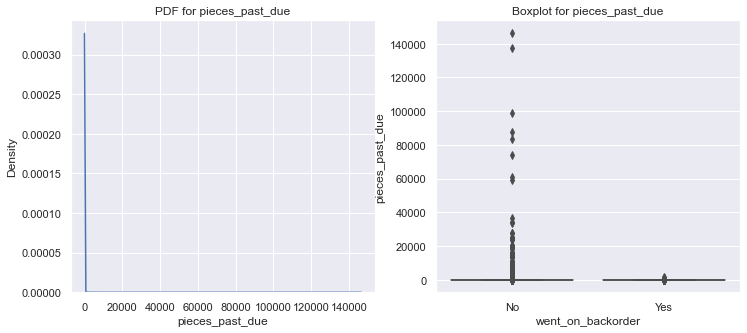

In [35]:
f, axes = plt.subplots(1, 2,figsize=(12,5))


sns.kdeplot(train_x['pieces_past_due'],ax=axes[0]).set_title("PDF for pieces_past_due")
plt.ticklabel_format(style='plain', axis='y')
sns.boxplot(y='pieces_past_due',x='went_on_backorder',data=train_data,ax=axes[1]).set_title("Boxplot for pieces_past_due")
plt.ticklabel_format(style='plain', axis='y')

#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

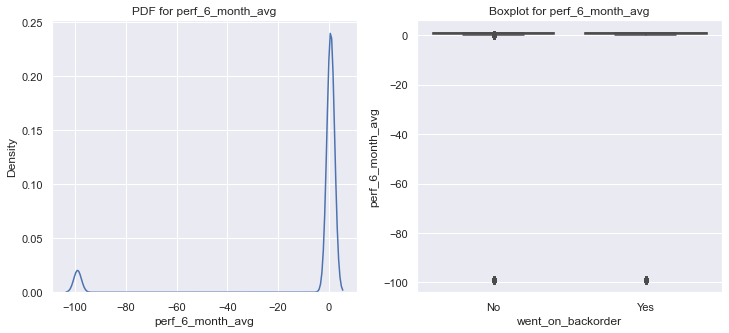

In [36]:
f, axes = plt.subplots(1, 2,figsize=(12,5))


sns.kdeplot(train_x['perf_6_month_avg'],ax=axes[0]).set_title("PDF for perf_6_month_avg")
plt.ticklabel_format(style='plain', axis='y')
sns.boxplot(y='perf_6_month_avg',x='went_on_backorder',data=train_data,ax=axes[1]).set_title("Boxplot for perf_6_month_avg")
plt.ticklabel_format(style='plain', axis='y')

#### Observation:
> Figures show high concentration of values at the zero and a slight aberration at -100<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

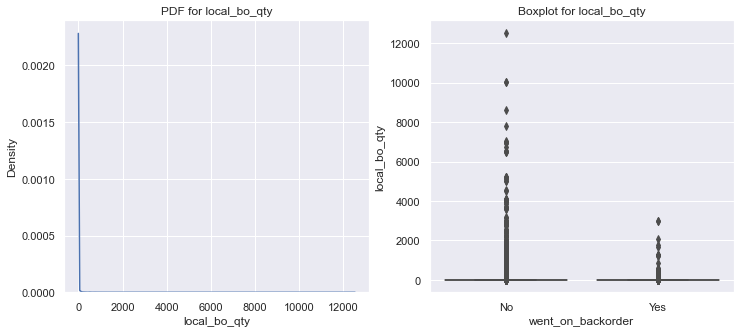

In [37]:
f, axes = plt.subplots(1, 2,figsize=(12,5))


sns.kdeplot(train_x['local_bo_qty'],ax=axes[0]).set_title("PDF for local_bo_qty")
plt.ticklabel_format(style='plain', axis='y')
sns.boxplot(y='local_bo_qty',x='went_on_backorder',data=train_data,ax=axes[1]).set_title("Boxplot for local_bo_qty")
plt.ticklabel_format(style='plain', axis='y')

#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

#### General Observations from above univariate analysis:
> It is observed that there is a high number of '0' values present<br>
> Further analysis will have to be done to check if '0' values are missing values or part of data

In [50]:
# Checking proportion of 0 values for each column

np.count_nonzero(train_x==0,axis=0)/train_x.shape[0]

array([0.06423815, 0.00622741, 0.79666679, 0.69776048, 0.64229912,
       0.61216037, 0.56865913, 0.44981515, 0.38334814, 0.34718164,
       0.51682663, 0.        , 0.98501712, 0.02311388, 0.01953657,
       0.98617065, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [32]:
# For each column, where backorder is present, checking the proportion of 0 values

np.set_printoptions(suppress=True) #Remove scientific notification
np.count_nonzero(train_data[train_data['went_on_backorder']=='Yes']==0,axis=0)/train_data[train_data['went_on_backorder']=='Yes'].shape[0]

array([0.        , 0.35003985, 0.01434517, 0.87425839, 0.14655096,
       0.10785442, 0.09483751, 0.27663154, 0.17311609, 0.14336315,
       0.1339768 , 0.50881077, 0.        , 0.90737625, 0.0509165 ,
       0.04595767, 0.87611795, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [39]:
# Creating a separate dataframe 'non-zero' for analysis on all non-zero values in columns

non_zero = train_data[train_data!=0]

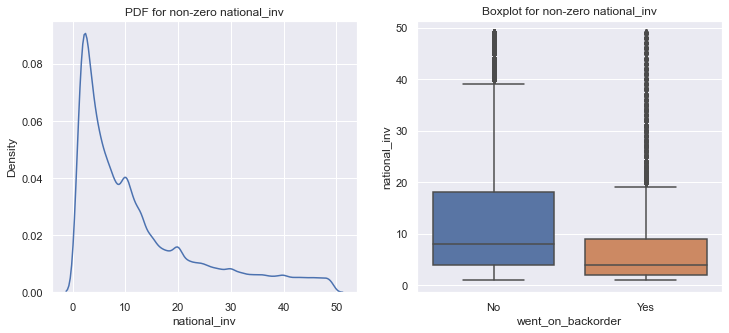

In [49]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.kdeplot(non_zero[(non_zero['national_inv']<50) & (non_zero['national_inv']>0)]['national_inv'],ax=axes[0]).set_title("PDF for non-zero national_inv")
sns.boxplot(y='national_inv',x='went_on_backorder',data=non_zero[(non_zero['national_inv']<50) & (non_zero['national_inv']>0)],ax=axes[1]).set_title("Boxplot for non-zero national_inv")
plt.show()

#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

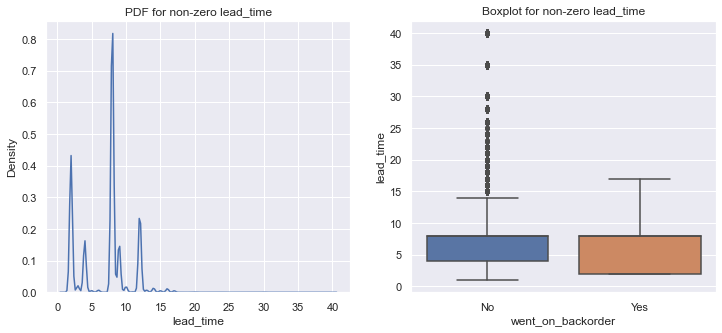

In [41]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.kdeplot(non_zero[non_zero['lead_time']<50]['lead_time'],ax=axes[0]).set_title("PDF for non-zero lead_time")
sns.boxplot(y='lead_time',x='went_on_backorder',data=non_zero[non_zero['lead_time']<50],ax=axes[1]).set_title("Boxplot for non-zero lead_time")
plt.show()

#### Observation:
> Figures show high concentration of values at the start in the range of approx 3-18 days<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

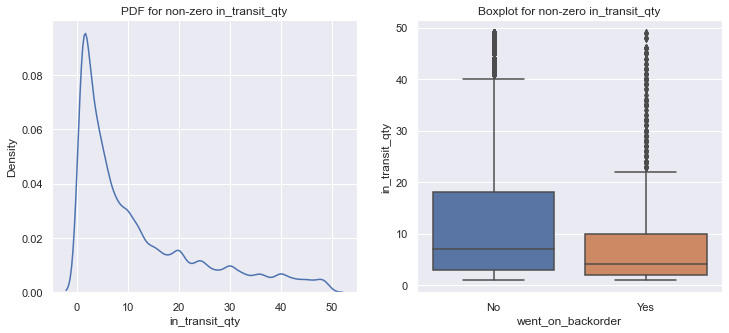

In [42]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.kdeplot(non_zero[non_zero['in_transit_qty']<50]['in_transit_qty'],ax=axes[0]).set_title("PDF for non-zero in_transit_qty")
sns.boxplot(y='in_transit_qty',x='went_on_backorder',data=non_zero[non_zero['in_transit_qty']<50],ax=axes[1]).set_title("Boxplot for non-zero in_transit_qty")
plt.show()

#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

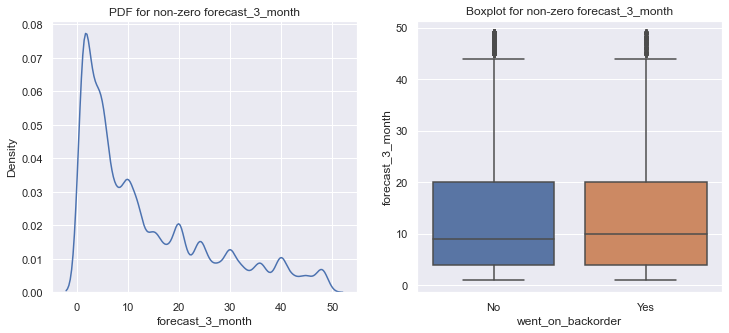

In [43]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.kdeplot(non_zero[non_zero['forecast_3_month']<50]['forecast_3_month'],ax=axes[0]).set_title("PDF for non-zero forecast_3_month")
sns.boxplot(y='forecast_3_month',x='went_on_backorder',data=non_zero[non_zero['forecast_3_month']<50],ax=axes[1]).set_title("Boxplot for non-zero forecast_3_month")
plt.show()

#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

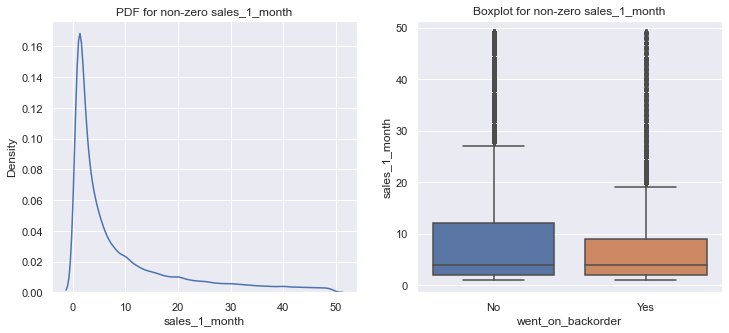

In [44]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.kdeplot(non_zero[non_zero['sales_1_month']<50]['sales_1_month'],ax=axes[0]).set_title("PDF for non-zero sales_1_month")
sns.boxplot(y='sales_1_month',x='went_on_backorder',data=non_zero[non_zero['sales_1_month']<50],ax=axes[1]).set_title("Boxplot for non-zero sales_1_month")
plt.show()

#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

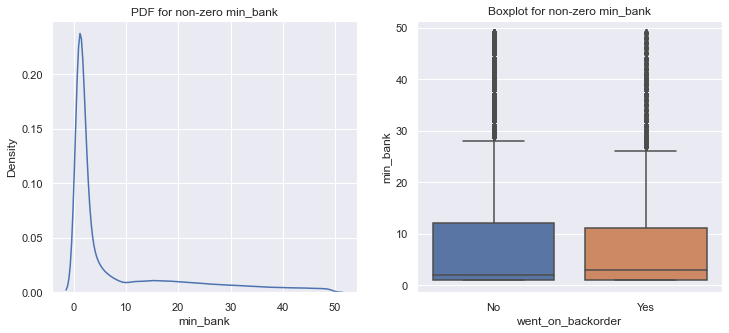

In [45]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.kdeplot(non_zero[non_zero['min_bank']<50]['min_bank'],ax=axes[0]).set_title("PDF for non-zero min_bank")
sns.boxplot(y='min_bank',x='went_on_backorder',data=non_zero[non_zero['min_bank']<50],ax=axes[1]).set_title("Boxplot for non-zero min_bank")
plt.show()

#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

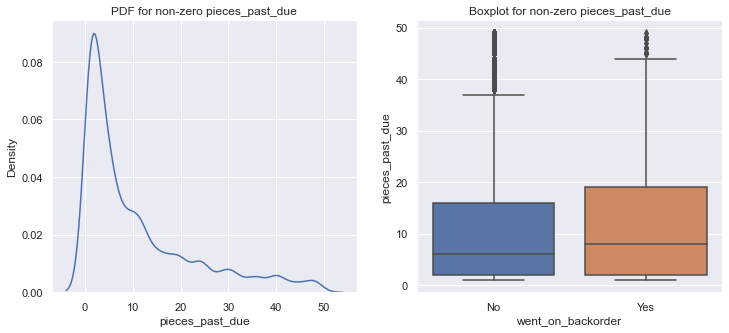

In [46]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.kdeplot(non_zero[non_zero['pieces_past_due']<50]['pieces_past_due'],ax=axes[0]).set_title("PDF for non-zero pieces_past_due")
sns.boxplot(y='pieces_past_due',x='went_on_backorder',data=non_zero[non_zero['pieces_past_due']<50],ax=axes[1]).set_title("Boxplot for non-zero pieces_past_due")
plt.show()

#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

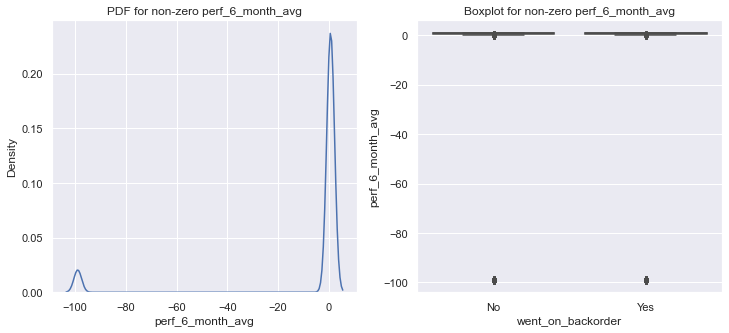

In [47]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.kdeplot(non_zero[non_zero['perf_6_month_avg']<50]['perf_6_month_avg'],ax=axes[0]).set_title("PDF for non-zero perf_6_month_avg")
sns.boxplot(y='perf_6_month_avg',x='went_on_backorder',data=non_zero[non_zero['perf_6_month_avg']<50],ax=axes[1]).set_title("Boxplot for non-zero perf_6_month_avg")
plt.show()

#### Observation:
> Figures show high concentration of values at the zero and a slight aberration at -100<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

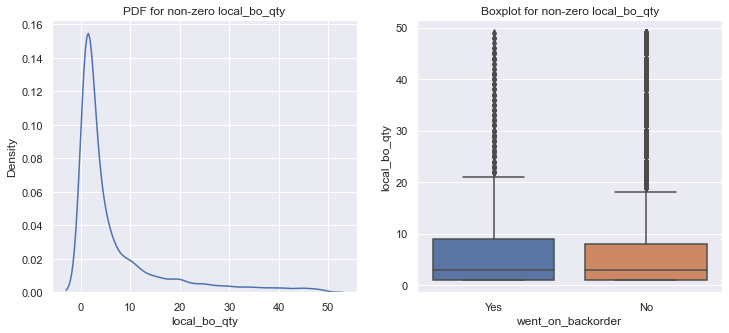

In [53]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.kdeplot(non_zero[non_zero['local_bo_qty']<50]['local_bo_qty'],ax=axes[0]).set_title("PDF for non-zero local_bo_qty")
sns.boxplot(y='local_bo_qty',x='went_on_backorder',data=non_zero[non_zero['local_bo_qty']<50],ax=axes[1]).set_title("Boxplot for non-zero local_bo_qty")
plt.show()

#### Observation:
> Figures show high concentration of values at the start (zero or near zero values)<br>
> No clear differention observed in the Boxplot for Yes and No Backorder classes

#### General Observations from above univariate analysis of non-zero rows:
> It can be seen that non-zero distributions are also long-tailed <br>
> Separability in the boxplots is also not easily observed<br>
> Zero valued rows can thus be considered as actual data

#### Analysis of categorical features:

C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'deck_risk')

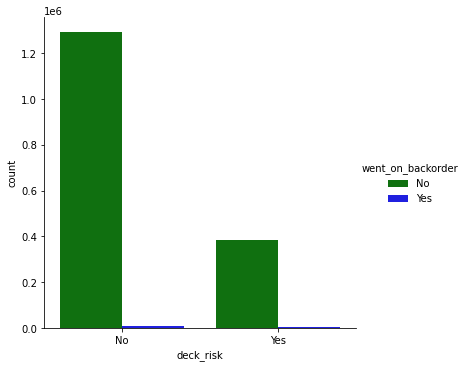

In [10]:
# https://medium.com/analytics-vidhya/tutorial-exploratory-data-analysis-eda-with-categorical-variables-6a569a3aea55
fig, ax = plt.subplots()

sns.catplot("deck_risk", hue="went_on_backorder", data=train_data, kind="count", 
            palette={"Yes":"blue", "No":"green"}, ax=ax)

plt.close(1) # catplot creates an extra figure we don't need

ax.set_xlabel("deck_risk")


In [60]:
deck_risk_yes_yes = len(train_data[(train_data['deck_risk']=='Yes')&(train_data['went_on_backorder']=='Yes')]['deck_risk'])/len(train_data[train_data['went_on_backorder']=='Yes']['deck_risk'])
deck_risk_no_yes = len(train_data[(train_data['deck_risk']=='Yes')&(train_data['went_on_backorder']=='No')]['deck_risk'])/len(train_data[train_data['went_on_backorder']=='No']['deck_risk'])

print("Percentage of deck_risk = 'Yes' for backorders: ",deck_risk_yes_yes*100,"%")
print("Percentage of deck_risk = 'Yes' for No backorders: ",deck_risk_no_yes*100,"%")

Percentage of deck_risk = 'Yes' for backorders:  16.96626228637209 %
Percentage of deck_risk = 'Yes' for No backorders:  22.997410780481783 %


#### Observation:
> No conclusive observation wrt to the predictability of backorders due to this feature<br>


C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'oe_constraint')

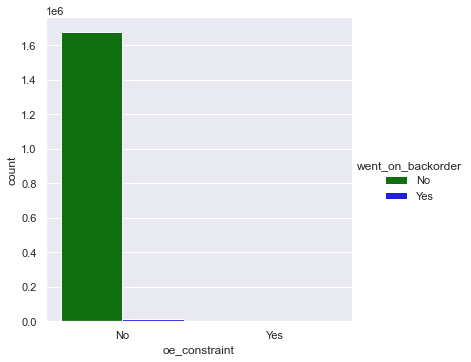

In [61]:
# https://medium.com/analytics-vidhya/tutorial-exploratory-data-analysis-eda-with-categorical-variables-6a569a3aea55
fig, ax = plt.subplots()

sns.catplot("oe_constraint", hue="went_on_backorder", data=train_data, kind="count", 
            palette={"Yes":"blue", "No":"green"}, ax=ax)

plt.close(1) # catplot creates an extra figure we don't need

ax.set_xlabel("oe_constraint")


In [63]:
oe_constraint_yes_yes = len(train_data[(train_data['oe_constraint']=='Yes')&(train_data['went_on_backorder']=='Yes')]['oe_constraint'])/len(train_data[train_data['went_on_backorder']=='Yes']['oe_constraint'])
oe_constraint_no_yes = len(train_data[(train_data['oe_constraint']=='Yes')&(train_data['went_on_backorder']=='No')]['oe_constraint'])/len(train_data[train_data['went_on_backorder']=='No']['oe_constraint'])

print("Percentage of oe_constraint = 'Yes' for backorders: ",oe_constraint_yes_yes*100,"%")
print("Percentage of oe_constraint = 'Yes' for No backorders: ",oe_constraint_no_yes*100,"%")

Percentage of oe_constraint = 'Yes' for backorders:  0.07084034357566635 %
Percentage of oe_constraint = 'Yes' for No backorders:  0.014136029159586228 %


#### Observation:
> No conclusive observation wrt to the predictability of backorders due to this feature<br>


C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'ppap_risk')

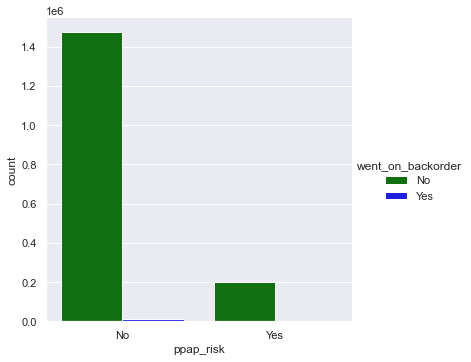

In [64]:
# https://medium.com/analytics-vidhya/tutorial-exploratory-data-analysis-eda-with-categorical-variables-6a569a3aea55
fig, ax = plt.subplots()

sns.catplot("ppap_risk", hue="went_on_backorder", data=train_data, kind="count", 
            palette={"Yes":"blue", "No":"green"}, ax=ax)

plt.close(1) # catplot creates an extra figure we don't need

ax.set_xlabel("ppap_risk")


In [65]:
ppap_risk_yes_yes = len(train_data[(train_data['ppap_risk']=='Yes')&(train_data['went_on_backorder']=='Yes')]['ppap_risk'])/len(train_data[train_data['went_on_backorder']=='Yes']['ppap_risk'])
ppap_risk_no_yes = len(train_data[(train_data['ppap_risk']=='Yes')&(train_data['went_on_backorder']=='No')]['ppap_risk'])/len(train_data[train_data['went_on_backorder']=='No']['ppap_risk'])

print("Percentage of ppap_risk = 'Yes' for backorders: ",ppap_risk_yes_yes*100,"%")
print("Percentage of ppap_risk = 'Yes' for No backorders: ",ppap_risk_no_yes*100,"%")

Percentage of ppap_risk = 'Yes' for backorders:  15.576020543699636 %
Percentage of ppap_risk = 'Yes' for No backorders:  12.052903343558594 %


#### Observation:
> No conclusive observation wrt to the predictability of backorders due to this feature<br>


C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'stop_auto_buy')

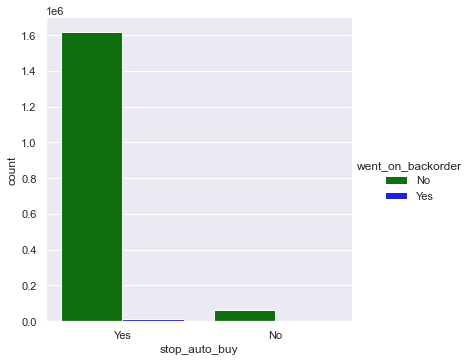

In [66]:
# https://medium.com/analytics-vidhya/tutorial-exploratory-data-analysis-eda-with-categorical-variables-6a569a3aea55
fig, ax = plt.subplots()

sns.catplot("stop_auto_buy", hue="went_on_backorder", data=train_data, kind="count", 
            palette={"Yes":"blue", "No":"green"}, ax=ax)

plt.close(1) # catplot creates an extra figure we don't need

ax.set_xlabel("stop_auto_buy")


In [67]:
stop_auto_buy_yes_yes = len(train_data[(train_data['stop_auto_buy']=='Yes')&(train_data['went_on_backorder']=='Yes')]['stop_auto_buy'])/len(train_data[train_data['went_on_backorder']=='Yes']['stop_auto_buy'])
stop_auto_buy_no_yes = len(train_data[(train_data['stop_auto_buy']=='Yes')&(train_data['went_on_backorder']=='No')]['stop_auto_buy'])/len(train_data[train_data['went_on_backorder']=='No']['stop_auto_buy'])

print("Percentage of stop_auto_buy = 'Yes' for backorders: ",stop_auto_buy_yes_yes*100,"%")
print("Percentage of stop_auto_buy = 'Yes' for No backorders: ",stop_auto_buy_no_yes*100,"%")

Percentage of stop_auto_buy = 'Yes' for backorders:  95.82927477198264 %
Percentage of stop_auto_buy = 'Yes' for No backorders:  96.38457633962734 %


#### Observation:
> No conclusive observation wrt to the predictability of backorders due to this feature<br>


C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sdiva\anaconda3\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'rev_stop')

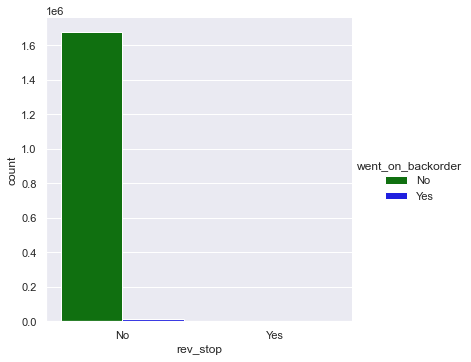

In [68]:
# https://medium.com/analytics-vidhya/tutorial-exploratory-data-analysis-eda-with-categorical-variables-6a569a3aea55
fig, ax = plt.subplots()

sns.catplot("rev_stop", hue="went_on_backorder", data=train_data, kind="count", 
            palette={"Yes":"blue", "No":"green"}, ax=ax)

plt.close(1) # catplot creates an extra figure we don't need

ax.set_xlabel("rev_stop")


In [69]:
rev_stop_yes_yes = len(train_data[(train_data['rev_stop']=='Yes')&(train_data['went_on_backorder']=='Yes')]['rev_stop'])/len(train_data[train_data['went_on_backorder']=='Yes']['rev_stop'])
rev_stop_no_yes = len(train_data[(train_data['rev_stop']=='Yes')&(train_data['went_on_backorder']=='No')]['rev_stop'])/len(train_data[train_data['went_on_backorder']=='No']['rev_stop'])

print("Percentage of rev_stop = 'Yes' for backorders: ",rev_stop_yes_yes*100,"%")
print("Percentage of rev_stop = 'Yes' for No backorders: ",rev_stop_no_yes*100,"%")

Percentage of rev_stop = 'Yes' for backorders:  0.0 %
Percentage of rev_stop = 'Yes' for No backorders:  0.043601001331888316 %


#### Observation:
> No conclusive observation wrt to the predictability of backorders due to this feature<br>


### General observations for categorical features:
> Of the categorical features, no clear separability can be seen

<AxesSubplot:>

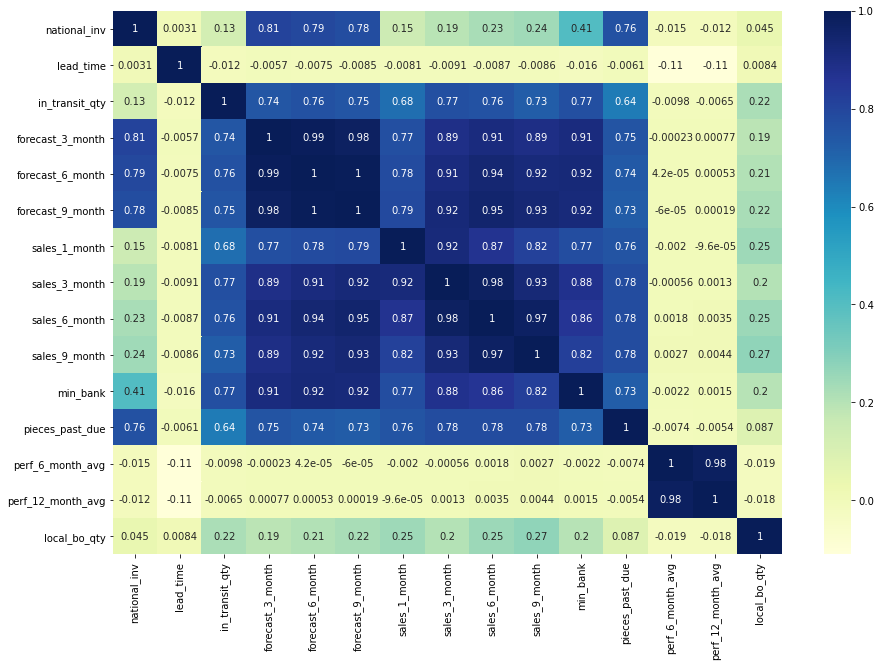

In [15]:
# Checking if high correlation between columns is due to high number of '0' value

non_zero_corr = non_zero.corr()
plt.figure(figsize=(15,10))
sns.heatmap(non_zero_corr,xticklabels = non_zero_corr.columns,yticklabels = non_zero_corr.columns,annot=True,cmap="YlGnBu")

In [17]:
# Storing correlated features for non-zero data

non_zero_corr_col_set = set()
nz_col_list = non_zero_corr.columns
for i in range(len(nz_col_list)):
    for j in range(len(nz_col_list)):
        if j<i:
            if abs(non_zero_corr.iloc[i,j]) > CORR_THRESHOLD:
                non_zero_corr_col_set.add(nz_col_list[i])

non_zero_corr_col_set

{'forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'min_bank',
 'perf_12_month_avg',
 'pieces_past_due',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month'}

In [23]:
# Converting all columns to numerical

x_processed = pd.get_dummies(train_x,drop_first=True)
train_y = pd.get_dummies(train_y, drop_first=True)

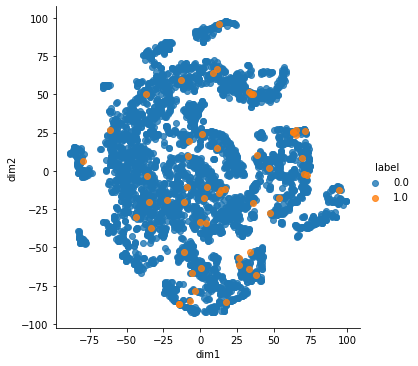

In [35]:
# Checking for class separation with T-SNE
# https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0
# Taking all the positive points and equalnumber of negative points for data represenation


x_combined = x_processed
x_combined['y'] = train_y

x_pro = x_combined[x_combined['y']==1]
x_pro = pd.concat([x_pro,x_combined[x_combined['y']==0][:len(x_pro)]])

rows = np.arange(x_pro.shape[0])
np.random.shuffle(rows)
n_select = 10000
x_embedded = TSNE(perplexity=30,learning_rate=200).fit_transform(x_pro.iloc[rows[:n_select],:])
df_tsne = pd.DataFrame(x_embedded, columns=['dim1', 'dim2'])
df_tsne['label'] = train_y.iloc[rows[:n_select]]
sns.lmplot(x='dim1', y='dim2', data=df_tsne, hue='label', fit_reg=False)

In [29]:
x_processed.shape

(1586967, 21)

In [38]:
# Dropping co-related features

corr_col_set.discard("forecast_3_month")
corr_col_set.discard("sales_1_month")
train_x_final = train_x.drop(labels = corr_col_set,axis=1)
x_processed = pd.get_dummies(train_x_final,drop_first=True)

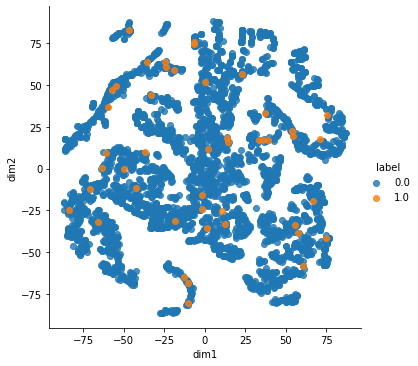

In [45]:
# Checking if dropping of co-related feautres has any effect

x_combined = x_processed
x_combined['y'] = train_y

x_pro = x_combined[x_combined['y']==1]
x_pro = pd.concat([x_pro,x_combined[x_combined['y']==0][:len(x_pro)]])

rows = np.arange(x_pro.shape[0])
np.random.shuffle(rows)
n_select = 10000
x_embedded = TSNE(perplexity=30,learning_rate=200).fit_transform(x_pro.iloc[rows[:n_select],:-1])
df_tsne = pd.DataFrame(x_embedded, columns=['dim1', 'dim2'])
df_tsne['label'] = x_pro.iloc[rows[:n_select],-1]
sns.lmplot(x='dim1', y='dim2', data=df_tsne, hue='label', fit_reg=False)

#### T-sne Observations:
> Data is not easily separable <br>
> Dropping of correlated features did not yeild significant differences

## EDA conclusions:

1. Data is highly imbalanced (approx 1:133)
2. Many numeric columns are correlated
3. Feature 'lead_time' has 6.25% values as null. These rows can be omitted without much loss of information
4. Many of the numeric columns have '0' as the most frequent value
5. But this does not seem like missing data, rather they can be treated as actual data based on our analysis
6. T-SNE analyis shows that data is not easily separable, tools like ensemble learning/complex methods may have to be applied
7. One doubt is whether at all forecast 3-6-9 month forecasts can help predict backorders for next week
8. Because of imbalanced data, accuracy metric is not helpful. Other metrics like Precision-Recall, AUROC etc will have to be considered
9. Not only is predicting backorder important, but also it is a high cost on the inventory if we wrongly predict the backorder
10. Hence, both precision and recall are very important as a metric for this case study.